In [2]:
import numpy as np
import cv2
import keras
import matplotlib.pyplot as plt 

2023-10-28 15:32:22.186902: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-28 15:32:22.203276: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-28 15:32:22.297516: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-28 15:32:22.297657: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-28 15:32:22.298056: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

# JPEG Compression

In [3]:

# Load the image
img = cv2.imread('data/sample/input_image.jpg')

# Convert the image to YCrCb color space
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


# Define the desired size for the subsampled image
new_width = img.shape[0]//2  # Set to half of the original width
new_height = img.shape[1]//2  # Set to half of the original height

# Resize the image to the desired size for subsampling
subsampled_image = cv2.resize(img, (new_width, new_height))


# Perform Huffman encoding
retval, buf = cv2.imencode('.jpg', subsampled_image, [cv2.IMWRITE_JPEG_QUALITY, 10])

# Save the compressed image
with open('data/sample/compressed_image.jpg', 'wb') as f:
    f.write(buf)

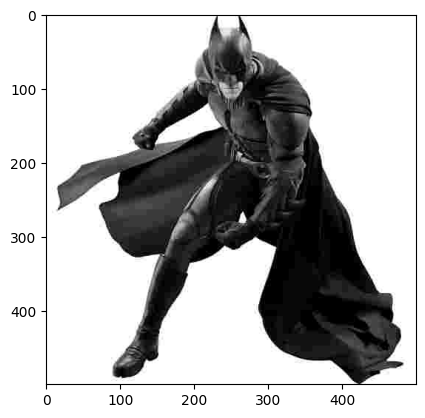

In [4]:
compressed_img = cv2.imread('data/sample/compressed_image.jpg')

plt.imshow(compressed_img)

In [5]:
import numpy as np
def get_jpeg_data(img, out_length=50):
  # Load the image

  # Convert the image to YCrCb color space
  # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


  # Define the desired size for the subsampled image
  new_width = img.shape[0]//2  # Set to half of the original width
  new_height = img.shape[1]//2  # Set to half of the original height

  # Resize the image to the desired size for subsampling
  subsampled_image = cv2.resize(img, (new_width, new_height))

  # Perform JPEG encoding
  retval, buf = cv2.imencode('.jpg', subsampled_image, [cv2.IMWRITE_JPEG_QUALITY, 10])

  def find_matching_slice(byte_list, target_slice):
      for i in range(len(byte_list) - len(target_slice) + 1):
          if byte_list[i:i + len(target_slice)] == target_slice:
              return i
      return -1


  # Example: Create a NumPy array containing a sequence of bytes (replace this with your actual data)
  # byte_sequence = np.array([0xFF, 0xDA, 0x00, 0x11, 0x00, 0x11,  0xFF, 0xD9, 0x11, 0xD9, 0xEE], dtype=np.uint8)

  # Convert the NumPy array to a regular Python list
  # byte_list = byte_sequence.tolist()

  byte_list = buf.tolist()

  # Define the start and end sequences to search for
  start_sequence = [0xFF, 0xDA]
  end_sequence = [0xFF, 0xD9]

  # Find the starting and ending indices
  start_index = find_matching_slice(byte_list, start_sequence)
  end_index = find_matching_slice(byte_list, end_sequence)

  # Extract the data between start and end sequences
  if start_index != -1 and end_index != -1:
      extracted_data = byte_list[start_index + len(start_sequence):end_index]
      # Convert the extracted data back to a NumPy array if needed
      extracted_data_np = np.array(extracted_data, dtype=np.uint8)

      # Pad to fixed size
      if extracted_data_np.shape[0] < out_length:
        pad_width = out_length - extracted_data_np.shape[0]
        extracted_data_np = np.pad(extracted_data_np, (0, pad_width), mode='constant', constant_values=0)
      if extracted_data_np.shape[0] > out_length:
         extracted_data_np = extracted_data_np[:out_length]
      # print("Extracted data:", extracted_data_np)
      # print("Data Length: ", len(extracted_data_np))
  else:
      print("Start and end sequences not found in the data.")
  return extracted_data_np

In [13]:
# Example of JPEG Compression
get_jpeg_data(cv2.imread('data/sample/compressed_image.jpg'), out_length=50)

array([  0,  12,   3,   1,   0,   2,  17,   3,  17,   0,  63,   0, 187,
        69,  20,  80,   1,  69,  20,  80,   1,  69,  20,  80,   1,  69,
        20,  80,   1,  69,  20,  80,   1,  69,  20,  80,   1,  69,  20,
       214,  59,  84, 159,  65,  64,  12, 142,  77, 243,  72], dtype=uint8)

# Compress and Prepare MNIST Dataset

In [29]:
from keras.datasets import mnist

# Load the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()


In [30]:
train_images.shape

(60000, 28, 28)

In [31]:
digits = [0, 1]
train_filter = np.isin(train_labels, digits)
train_images = train_images[train_filter]
test_filter = np.isin(test_labels, digits)
test_images = test_images[test_filter]

In [32]:
# Convert to JPEG embedding
train_images_jpeg = np.zeros((train_images.shape[0], 50))
for i in range(len(train_images)):
    train_images_jpeg[i] = get_jpeg_data(train_images[i])

test_images_jpeg = np.zeros((test_images.shape[0], 50))
for i in range(len(test_images)):
    test_images_jpeg[i] = get_jpeg_data(test_images[i])

In [44]:
print(f'Train data: {train_images_jpeg.shape}')
print(f'Test data: {test_images_jpeg.shape}')


Train data: (12665, 50)
Test data: (2115, 50)


# Train a Classical model on JPEG data




In [14]:
def Model1():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([

        keras.layers.Dense(30),
        keras.layers.Dense(15),
        keras.layers.Dense(10, activation="softmax")
    ])
    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [15]:
c_model = Model1()

c_history = c_model.fit(
    train_images_jpeg,
    train_labels[train_filter],
    validation_split=0.2,
    batch_size=16,
    epochs=30,
    verbose=2,
)

Epoch 1/30


2023-10-28 14:39:45.201455: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-28 14:39:45.371116: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


634/634 - 1s - loss: 5.3801 - accuracy: 0.9202 - val_loss: 0.8569 - val_accuracy: 0.9360 - 1s/epoch - 2ms/step
Epoch 2/30
634/634 - 1s - loss: 0.9415 - accuracy: 0.9407 - val_loss: 0.4547 - val_accuracy: 0.9649 - 839ms/epoch - 1ms/step
Epoch 3/30
634/634 - 1s - loss: 0.7188 - accuracy: 0.9404 - val_loss: 0.4421 - val_accuracy: 0.9621 - 765ms/epoch - 1ms/step
Epoch 4/30
634/634 - 1s - loss: 0.5446 - accuracy: 0.9406 - val_loss: 0.3544 - val_accuracy: 0.9621 - 847ms/epoch - 1ms/step
Epoch 5/30
634/634 - 1s - loss: 0.5207 - accuracy: 0.9410 - val_loss: 0.3131 - val_accuracy: 0.9534 - 975ms/epoch - 2ms/step
Epoch 6/30
634/634 - 1s - loss: 0.4295 - accuracy: 0.9421 - val_loss: 0.3205 - val_accuracy: 0.9400 - 765ms/epoch - 1ms/step
Epoch 7/30
634/634 - 1s - loss: 0.3714 - accuracy: 0.9419 - val_loss: 0.2905 - val_accuracy: 0.9613 - 773ms/epoch - 1ms/step
Epoch 8/30
634/634 - 1s - loss: 0.2952 - accuracy: 0.9450 - val_loss: 0.2968 - val_accuracy: 0.9491 - 800ms/epoch - 1ms/step
Epoch 9/30
634

In [17]:
# Evaluate the model on the test data to compute accuracy
loss, accuracy = c_model.evaluate(test_images_jpeg, test_labels[test_filter])

# Print the accuracy
print(f'Test accuracy: {accuracy}')

67/67 [==============================] - 0s 1ms/step - loss: 0.2991 - accuracy: 0.9154
Test accuracy: 0.9153664112091064


# Train a Classical Model with Convolution Layer


In [18]:
train_images.shape

(12665, 28, 28)

In [19]:
def Model2():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Conv2D(32,(2,2),activation='relu'),
        keras.layers.Flatten(),
        keras.layers.Dense(12),
        keras.layers.Dense(10, activation="softmax")
    ])
    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [20]:
c_model2 = Model2()
train_images = train_images.reshape((12665, 28, 28, 1)).astype('float32')

c_history2 = c_model2.fit(
    train_images,
    train_labels[train_filter],
    validation_split=0.2,
    batch_size=16,
    epochs=10,
    verbose=2,
)

Epoch 1/10
634/634 - 3s - loss: 0.4068 - accuracy: 0.9948 - val_loss: 0.0784 - val_accuracy: 0.9976 - 3s/epoch - 5ms/step
Epoch 2/10
634/634 - 2s - loss: 0.0871 - accuracy: 0.9976 - val_loss: 0.0285 - val_accuracy: 0.9992 - 2s/epoch - 4ms/step
Epoch 3/10
634/634 - 2s - loss: 0.0197 - accuracy: 0.9994 - val_loss: 0.0236 - val_accuracy: 0.9996 - 2s/epoch - 4ms/step
Epoch 4/10
634/634 - 3s - loss: 0.0506 - accuracy: 0.9987 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - 3s/epoch - 4ms/step
Epoch 5/10
634/634 - 2s - loss: 0.0275 - accuracy: 0.9995 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - 2s/epoch - 4ms/step
Epoch 6/10
634/634 - 3s - loss: 0.0074 - accuracy: 0.9998 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - 3s/epoch - 4ms/step
Epoch 7/10
634/634 - 2s - loss: 0.0201 - accuracy: 0.9996 - val_loss: 8.3583e-04 - val_accuracy: 0.9996 - 2s/epoch - 4ms/step
Epoch 8/10
634/634 - 2s - loss: 0.0485 - accuracy: 0.9989 - val_loss: 0.0653 - val_accuracy: 0.9980 - 2s/epoch - 4ms/step
Epoch 9/

In [21]:
# Evaluate the model on the test data to compute accuracy
loss, accuracy = c_model2.evaluate(test_images, test_labels[test_filter])

# Print the accuracy
print(f'Test accuracy: {accuracy}')

67/67 [==============================] - 0s 2ms/step - loss: 0.0021 - accuracy: 0.9995
Test accuracy: 0.9995272159576416


# Train a Quantum Model

In [45]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer, GradientDescentOptimizer


In [50]:
dev = qml.device("lightning.qubit", wires=1)
# Install any pennylane-plugin to run on some particular backend


def reshape_x(x):
    # Calculate the number of subarrays needed
    num_subarrays = len(input_array) // 3 + (len(input_array) % 3 != 0)

    # Split the array into subarrays of size 3
    subarrays = [input_array[i * 3:(i + 1) * 3] for i in range(num_subarrays)]

    # Check if the last subarray has fewer than 3 elements and pad with zeros if necessary
    if len(subarrays[-1]) < 3:
        subarrays[-1] = np.pad(subarrays[-1], (0, 3 - len(subarrays[-1])), mode='constant')
        
    return subarrays


@qml.qnode(dev, interface="autograd")
def qcircuit(params, x, y):
    """A variational quantum circuit representing the Universal classifier.

    Args:
        params (array[float]): array of parameters of dim (num_layers, 3)
        x (array[float]): single input vector 
        y (array[float]): single output state density matrix

    Returns:
        float: fidelity between output state and input
    """
    
    x = reshape_x(x)
    
    for p in params: # Iterate num_layers times
        for x_sub in x:
            qml.Rot(*x_sub, wires=0)
        qml.Rot(*p, wires=0)
    return qml.expval(qml.Hermitian(y, wires=[0]))


def cost(params, x, y, state_labels=None):
    """Cost function to be minimized.

    Args:
        params (array[float]): array of parameters
        x (array[float]): 2-d array of input vectors
        y (array[float]): 1-d array of targets
        state_labels (array[float]): array of state representations for labels

    Returns:
        float: loss value to be minimized
    """
    # Compute prediction for each input in data batch
    loss = 0.0
    dm_labels = [density_matrix(s) for s in state_labels]
    for i in range(len(x)):
        f = qcircuit(params, x[i], dm_labels[y[i]])
        loss = loss + (1 - f) ** 2
    return loss / len(x)

### Utility functions for testing and creating batches



In [47]:
def test(params, x, y, state_labels=None):
    """
    Tests on a given set of data.

    Args:
        params (array[float]): array of parameters
        x (array[float]): 2-d array of input vectors
        y (array[float]): 1-d array of targets
        state_labels (array[float]): 1-d array of state representations for labels

    Returns:
        predicted (array([int]): predicted labels for test data
        output_states (array[float]): output quantum states from the circuit
    """
    fidelity_values = []
    dm_labels = [density_matrix(s) for s in state_labels]
    predicted = []

    for i in range(len(x)):
        fidel_function = lambda y: qcircuit(params, x[i], y)
        fidelities = [fidel_function(dm) for dm in dm_labels]
        best_fidel = np.argmax(fidelities)

        predicted.append(best_fidel)
        fidelity_values.append(fidelities)

    return np.array(predicted), np.array(fidelity_values)


def accuracy_score(y_true, y_pred):
    """Accuracy score.

    Args:
        y_true (array[float]): 1-d array of targets
        y_predicted (array[float]): 1-d array of predictions
        state_labels (array[float]): 1-d array of state representations for labels

    Returns:
        score (float): the fraction of correctly classified samples
    """
    score = y_true == y_pred
    return score.sum() / len(y_true)


def iterate_minibatches(inputs, targets, batch_size):
    """
    A generator for batches of the input data

    Args:
        inputs (array[float]): input data
        targets (array[float]): targets

    Returns:
        inputs (array[float]): one batch of input data of length `batch_size`
        targets (array[float]): one batch of targets of length `batch_size`
    """
    for start_idx in range(0, inputs.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield inputs[idxs], targets[idxs]

In [48]:
# Define output labels as quantum state vectors for binary classification

def density_matrix(state):
    """Calculates the density matrix representation of a state.

    Args:
        state (array[complex]): array representing a quantum state vector

    Returns:
        dm: (array[complex]): array representing the density matrix
    """
    return state * np.conj(state).T


label_0 = [[1], [0]] # Digit Zero 
label_1 = [[0], [1]] # Digit One
state_labels = np.array([label_0, label_1], requires_grad=False)

In [53]:
# set training and test data
subset = 500
X_train = train_images_jpeg[:subset]
y_train = train_labels[train_filter][:subset]
X_test = test_images_jpeg[:subset]
y_test = test_labels[test_filter][:subset]

# Train using Adam optimizer and evaluate the classifier
num_layers = 5
learning_rate = 0.6
epochs = 10
batch_size = 32

opt = AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)

# initialize random weights
params = np.random.uniform(size=(num_layers, 3), requires_grad=True)

predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
accuracy_train = accuracy_score(y_train, predicted_train)

predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
accuracy_test = accuracy_score(y_test, predicted_test)

# save predictions with random weights for comparison
initial_predictions = predicted_test

loss = cost(params, X_test, y_test, state_labels)

print(
    "Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(
        0, loss, accuracy_train, accuracy_test
    )
)

for it in range(epochs):
    for Xbatch, ybatch in iterate_minibatches(X_train, y_train, batch_size=batch_size):
        params, _, _, _ = opt.step(cost, params, Xbatch, ybatch, state_labels)

    predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
    accuracy_train = accuracy_score(y_train, predicted_train)
    loss = cost(params, X_train, y_train, state_labels)

    predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
    accuracy_test = accuracy_score(y_test, predicted_test)
    res = [it + 1, loss, accuracy_train, accuracy_test]
    print(
        "Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(
            *res
        )
    )

Epoch:  0 | Cost: 0.551027 | Train accuracy: 0.458000 | Test Accuracy: 0.428000
Epoch:  1 | Loss: 0.288169 | Train accuracy: 0.542000 | Test accuracy: 0.572000
Epoch:  2 | Loss: 0.283593 | Train accuracy: 0.542000 | Test accuracy: 0.572000
Epoch:  3 | Loss: 0.262985 | Train accuracy: 0.542000 | Test accuracy: 0.572000
Epoch:  4 | Loss: 0.263786 | Train accuracy: 0.542000 | Test accuracy: 0.572000
Epoch:  5 | Loss: 0.258921 | Train accuracy: 0.542000 | Test accuracy: 0.572000
Epoch:  6 | Loss: 0.258390 | Train accuracy: 0.542000 | Test accuracy: 0.572000
Epoch:  7 | Loss: 0.257766 | Train accuracy: 0.542000 | Test accuracy: 0.572000
Epoch:  8 | Loss: 0.261733 | Train accuracy: 0.542000 | Test accuracy: 0.572000
Epoch:  9 | Loss: 0.271029 | Train accuracy: 0.458000 | Test accuracy: 0.428000
Epoch: 10 | Loss: 0.299868 | Train accuracy: 0.458000 | Test accuracy: 0.428000


In [54]:
print(params)

[[-2.01445574 -2.3309029  -0.19788889]
 [-2.70179765 -2.90047854 -0.14583373]
 [-1.64338179 -2.97830666  0.12735715]
 [ 1.1026736   2.69781399 -1.22472403]
 [ 2.64426527 -0.00361373  0.90556887]]
